# Stationary state 5

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import pickle

import sys
sys.path.append('../tests/')
from test_solving_KEs_complete import *

In [29]:
"""Complete case test."""
# setup
# TODO: increase these values
N = 100
I0 = 1
time_max = 20

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = Complete Hypergraph, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = Complete Hypergraph, N = 100, I0 = 1

	beta1 = 0.02, beta2 = 0.0004, mu = 1



In [30]:
eps = 1e-5 # shift for esp to not start with 0 !

beta1_max = 0.03
beta2_max = 0.0007

beta1_steps = 25
beta2_steps = 25

beta1_vec = np.linspace(eps, beta1_max, beta1_steps)
beta2_vec = np.linspace(eps, beta2_max, beta2_steps)

print(f"beta1: {beta1_vec[:5]}, ..., {beta1_vec[-3:-1]}")
print(f"beta2: {beta2_vec[:5]}, ..., {beta2_vec[-3:-1]}")


beta1: [1.00000000e-05 1.25958333e-03 2.50916667e-03 3.75875000e-03
 5.00833333e-03], ..., [0.02750083 0.02875042]
beta2: [1.000e-05 3.875e-05 6.750e-05 9.625e-05 1.250e-04], ..., [0.0006425  0.00067125]


In [31]:
k_star = np.zeros((beta1_steps, beta2_steps)) # to store the values k^* = E[X(t_max)]

In [32]:
M = N + 1 # number of all states

# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)

p0 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [33]:
solve_for_betas = True
# save solutions to run it once
file_path = '../results/solutions_stationary_state_linspace_2.pickle'

if solve_for_betas:
    solutions = {}
    for i, beta1 in enumerate(beta1_vec):
        for j, beta2 in enumerate(beta2_vec):
            ode_system_complete = list_all_ODEs_complete(N, beta1, beta2, mu)

            def f_ode(t, p):
                return ode_system_complete(t, p)

            sol = solve_ivp(f_ode, 
                            t_span, 
                            p0, 
                            t_eval=t_eval,
                            method="LSODA"
            )
            solutions[str((i, j))] = sol
    # save the solutions
    with open(file_path, "wb") as f:
        pickle.dump(solutions, f)
else:
    # load solutions
    with open(file_path, "rb") as f:
        solutions = pickle.load(f)

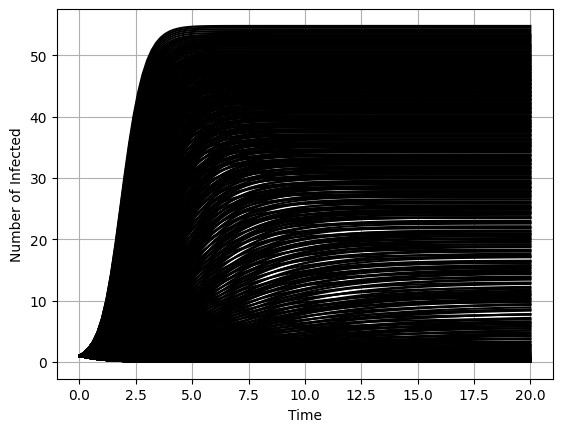

In [34]:
# plot expected values of p_{k}(t) over time t

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):
        sol = solutions[str((i, j))]
        expected_values = calculate_expected_values(sol)
        
        k_star[i, j] = expected_values[-1]

        plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state_linspace_2_I0=1.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

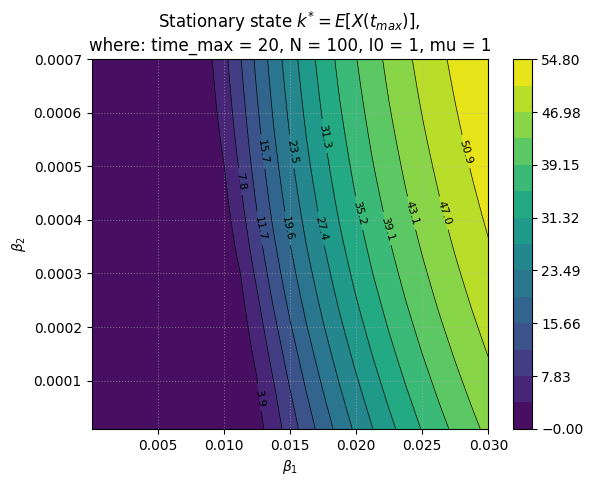

In [35]:
B1, B2 = np.meshgrid(beta1_vec, beta2_vec)
plt.figure()
levels = np.linspace(k_star.min(), k_star.max(), 15) # TODO: set levels

contourf_plot = plt.contourf(B1, B2, k_star.T, levels=levels, cmap='viridis') # use k_star.T!!
contour_plot = plt.contour(B1, B2, k_star.T, levels=contourf_plot.levels, colors='k', linewidths=0.5)

plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%.1f')

cbar = plt.colorbar(contourf_plot)
cbar.set_label(r'')

plt_title = r'Stationary state $k^{*} = E[X(t_{max})]$, '
plt_title += f"\nwhere: time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}"
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title(plt_title)
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state-contour_linspace_2_I0=1.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

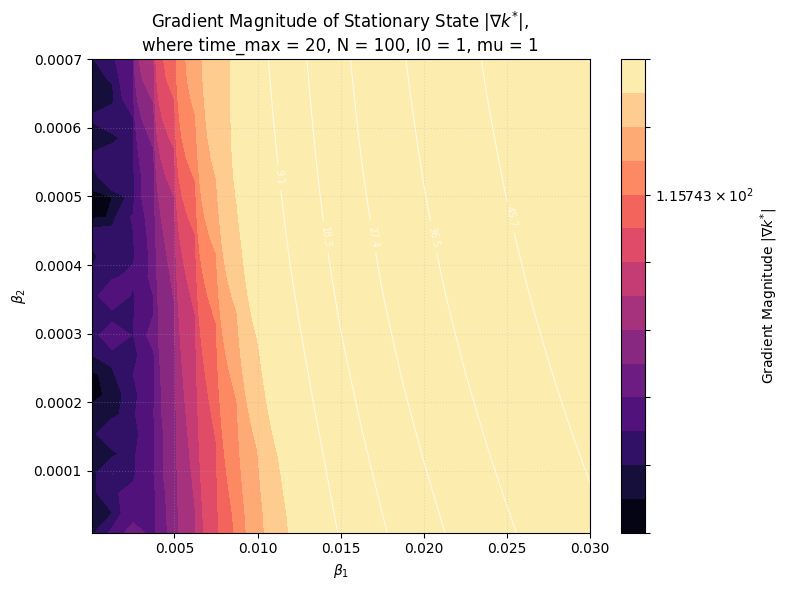

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # Import LogNorm for potential log scale

# --- Assuming you have B1, B2, k_star, beta1_vec, beta2_vec calculated ---
# B1, B2 = np.meshgrid(beta1_vec, beta2_vec)
# k_star = ... # Your results matrix, shape (len(beta2_vec), len(beta1_vec))

# Ensure k_star is oriented correctly for gradient calculation relative to plot axes
# If you plotted k_star.T, then axis 0 corresponds to beta2 and axis 1 to beta1
k_data_for_gradient = k_star.T # Use the same orientation as in your contour plot

# Calculate the gradient components
# np.gradient takes the data, then spacing along each axis.
# Axis 0 of k_data_for_gradient corresponds to beta2 (vertical in plot)
# Axis 1 of k_data_for_gradient corresponds to beta1 (horizontal in plot)
grad_beta2, grad_beta1 = np.gradient(k_data_for_gradient, beta2_vec, beta1_vec)

# Calculate the gradient magnitude
gradient_magnitude = np.sqrt(grad_beta1**2 + grad_beta2**2)

# --- Plotting the Gradient Magnitude ---
plt.figure(figsize=(8, 6)) # Adjust figure size if needed

# Choose levels for the gradient plot. Log spacing might be useful if it varies a lot.
# Option 1: Linear levels (start with this)
# grad_levels = np.linspace(gradient_magnitude.min(), gradient_magnitude.max(), 15)
# norm = None # Linear scale

# Option 2: Log levels (use if gradient spans orders of magnitude)
# Add a small epsilon to avoid log(0) issues if gradient can be exactly zero
epsilon = 1e-9
norm = LogNorm(vmin=np.maximum(gradient_magnitude.min(), epsilon), vmax=gradient_magnitude.max())
grad_levels = np.logspace(np.log10(np.maximum(gradient_magnitude.min(), epsilon)),
                          np.log10(gradient_magnitude.max()), 15)


contourf_plot_grad = plt.contourf(B1, B2, gradient_magnitude,
                                  levels=grad_levels, # Use chosen levels
                                  cmap='magma',      # 'magma' or 'plasma' often work well for magnitudes
                                  norm=norm)       # Use LogNorm if using log levels

cbar_grad = plt.colorbar(contourf_plot_grad)
cbar_grad.set_label(r'Gradient Magnitude $|\nabla k^{*}|$')

# Optional: Overlay contours of the original k* for context
# Use fewer, clearly distinct levels for the original k* contours here
k_star_context_levels = np.linspace(k_star.min(), k_star.max(), 7) # e.g., 7 levels
contour_plot_kstar = plt.contour(B1, B2, k_star.T,
                                 levels=k_star_context_levels,
                                 colors='white', # Use a contrasting color
                                 linewidths=0.8,
                                 alpha=0.7)      # Make them slightly transparent
plt.clabel(contour_plot_kstar, inline=True, fontsize=7, fmt='%.1f')


plt_title = r'Gradient Magnitude of Stationary State $|\nabla k^{*}|$, '
plt_title += f"\nwhere time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}" # Add your params
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title(plt_title)
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout() # Adjust layout

# --- Save the figure ---
# output_filename = "../figures/solutions-kolmogorov/complete/stationary-state-gradient_N{N}_I0{I0}.pdf" # Example filename
# plt.savefig(output_filename.format(N=N, I0=I0), format='pdf', bbox_inches='tight')

plt.show()